## Upload functions and necessary modules

In [1]:
from bb2022_functions import *
%matplotlib inline
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import SeqIO
pd.options.mode.chained_assignment = None  # default='warn'

## Import and format metadata

In [2]:
md = pd.read_csv("metadata_merged.csv")
merged = pd.read_csv("metadata_niskin.csv")
all_md = pd.read_csv("allmetadata.csv")

### Visualize metadata

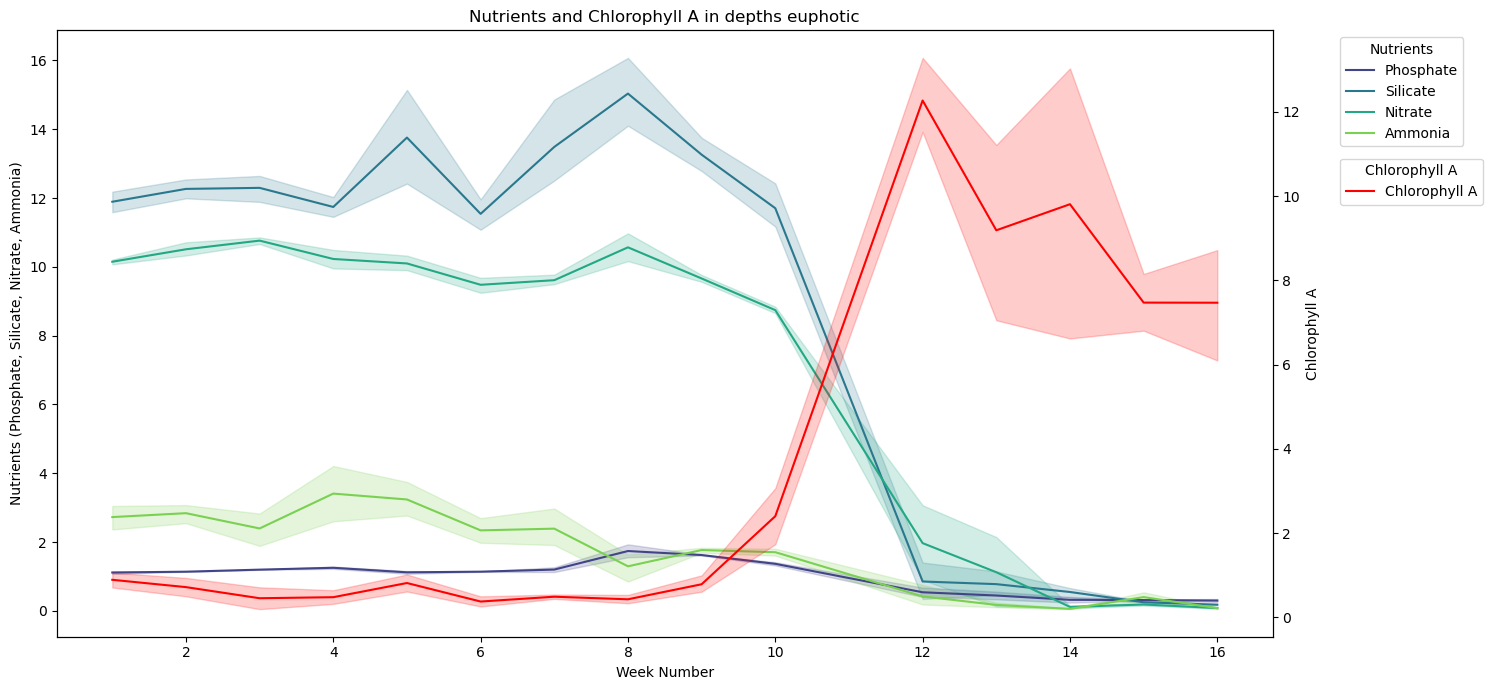

In [6]:
plot_nutrients(all_md, 'euphotic')

In [49]:
#print the max values for each variable
d1.loc[d1.groupby('variable')['value'].idxmax()]

,weekn,depth,variable,value
459,4.0,1.0,Ammonia,4.86350
696,14.0,5.0,Chlorophyll A,15.63077
357,8.0,10.0,Nitrate,11.38500
69,8.0,10.0,Phosphate,2.12100
213,8.0,10.0,Silicate,17.07500


## Add microbial communities

In [8]:
#generate a dataframe from all specified amplicon
df, comm = consolidate_tables('chloroplast') #frac='pooled') #16S, chloroplast, or 18S
merged = merge_metadata(df, all_md)
separated, contaminants = pick_metadata(comm, merged)
newseparated = make_defract(all_md, separated)

Community is 02-PROKs
Found all chloroplast tables.
Successfully saved all tables.
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos
Saved separated by metadata dataframe.
Community is chloroplast
Switched to cyanobacteria and chloroplast


In [9]:
#apply changes to taxonomy according to NCBI identified ASVs
newdf = apply_replacement(newseparated, "feature_id", "Genus") # or replace Genus with PRSpecies if dealing with phytoref

Values were updated


To generate MIMARKS file for NCBI sequence submission; the output is a .csv file for the samples and their metadata for submission (i.e sampleid, size fraction, date)

In [10]:
make_MIMARKS(newseparated)

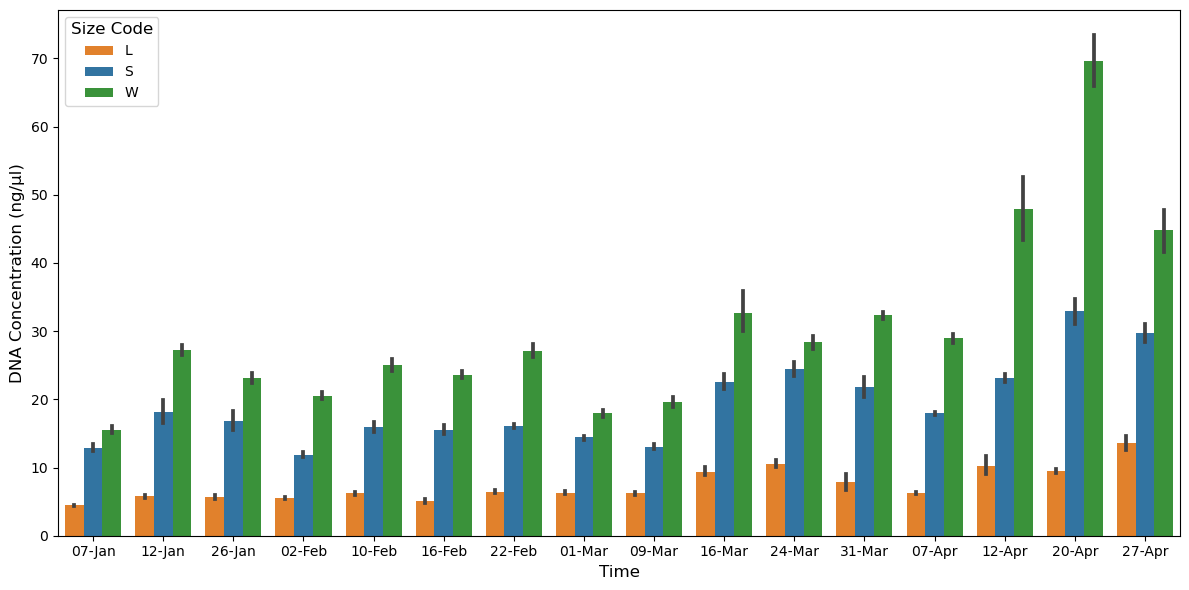

In [11]:
#plot of dna concentrations per sample
dnacon(newseparated, depth='all')

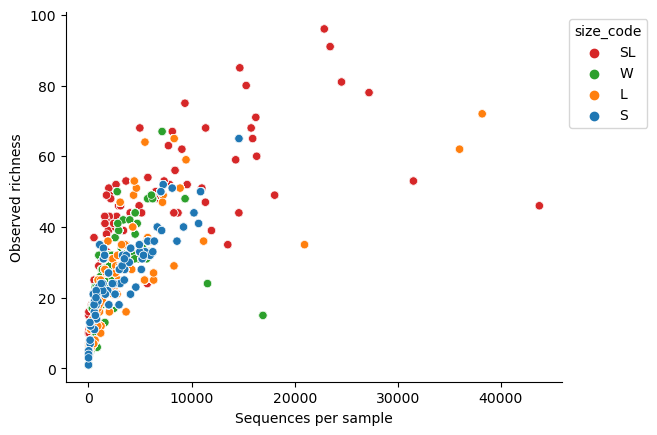

In [12]:
#rarefaction curves per community
rarefy_curve(comm, newseparated)

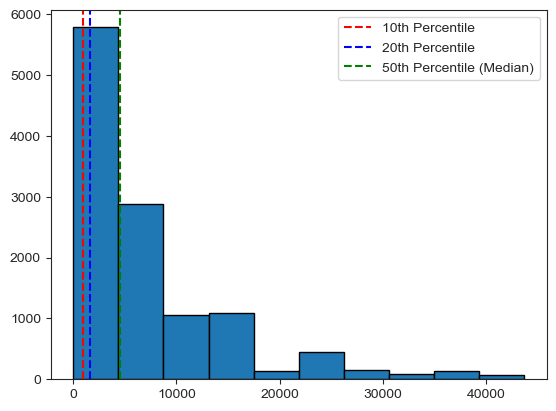

Suggested rarefaction depth: 4532


In [25]:
#plot sampling depth histogram to pick library depth for rarefying
plt.hist(newdf['Total'], bins=10, edgecolor='black')

# Add lines for quantiles
quantiles = [0.1, 0.2, 0.5]
colors = ['red', 'blue', 'green']
labels = ['10th Percentile', '20th Percentile', '50th Percentile (Median)']

for q, color, label in zip(quantiles, colors, labels):
    plt.axvline(x=newdf['Total'].quantile(q), color=color, linestyle='--', label=label)
plt.legend()

# Save and show the plot
plt.savefig('sampling_depths.png', dpi=300, bbox_inches='tight')
plt.show()

# Suggest a rarefaction depth
suggested_depth = int(newdf['Total'].quantile(0.5))
print(f"Suggested rarefaction depth: {suggested_depth}")

We can also sort the samples by their library size:

In [13]:
newseparated[['Total','sampleid']].sort_values('Total').drop_duplicates()

,Total,sampleid
5926,3.000000,BB22.10A
7144,3.000000,BB22.10C
7496,3.000000,BB22.4D
11750,9.000000,BB22.1DS
5612,10.787879,BB22.1DSL
...,...,...
5649,27208.030303,BB22.1ASL
1269,31511.839465,BB22.14CSL
9578,35986.000000,BB22.13CL
9626,38178.000000,BB22.13AL


#### Explore the taxonomy in the samples and compare

In [15]:
#Produce interactive taxonomic barplots with plotly
phyld, top10d = taxbarplot(comm, newseparated, 'Genus', 5, 10, 'size_code')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


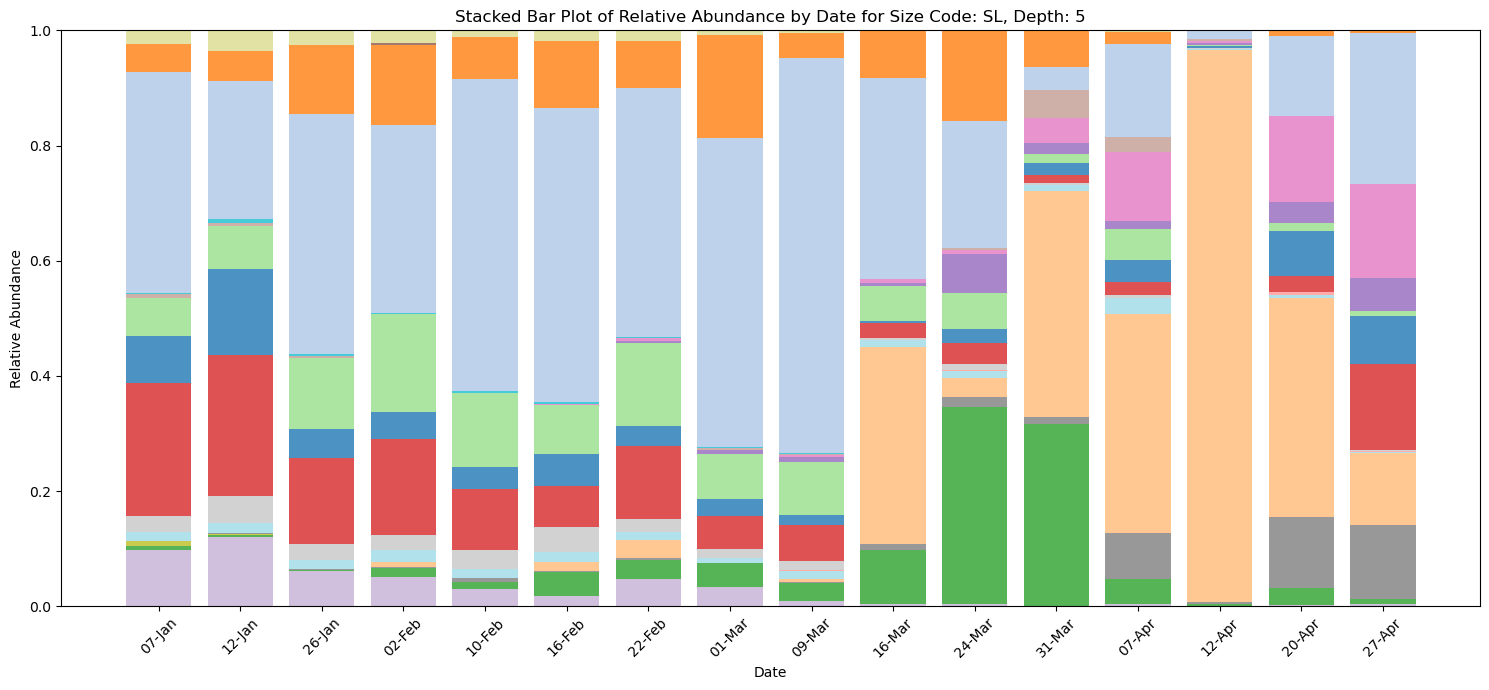

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


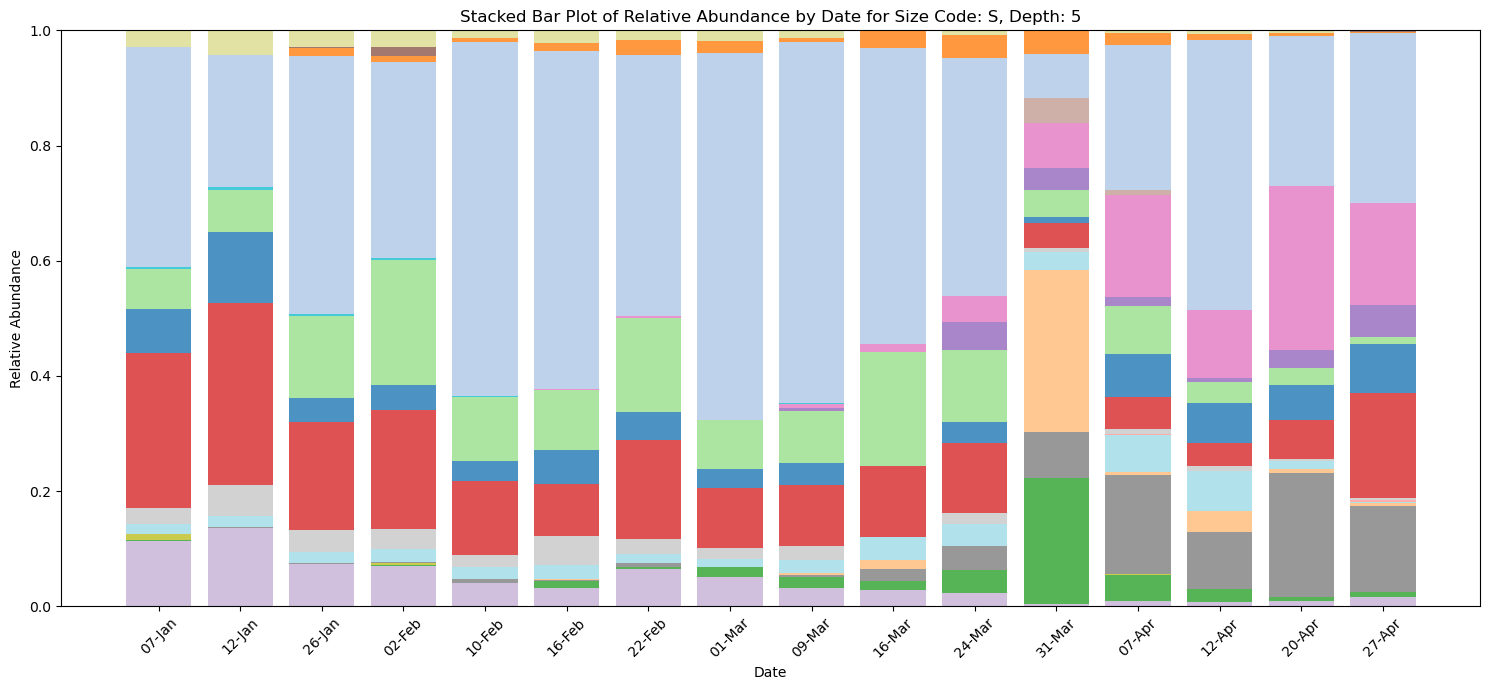

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


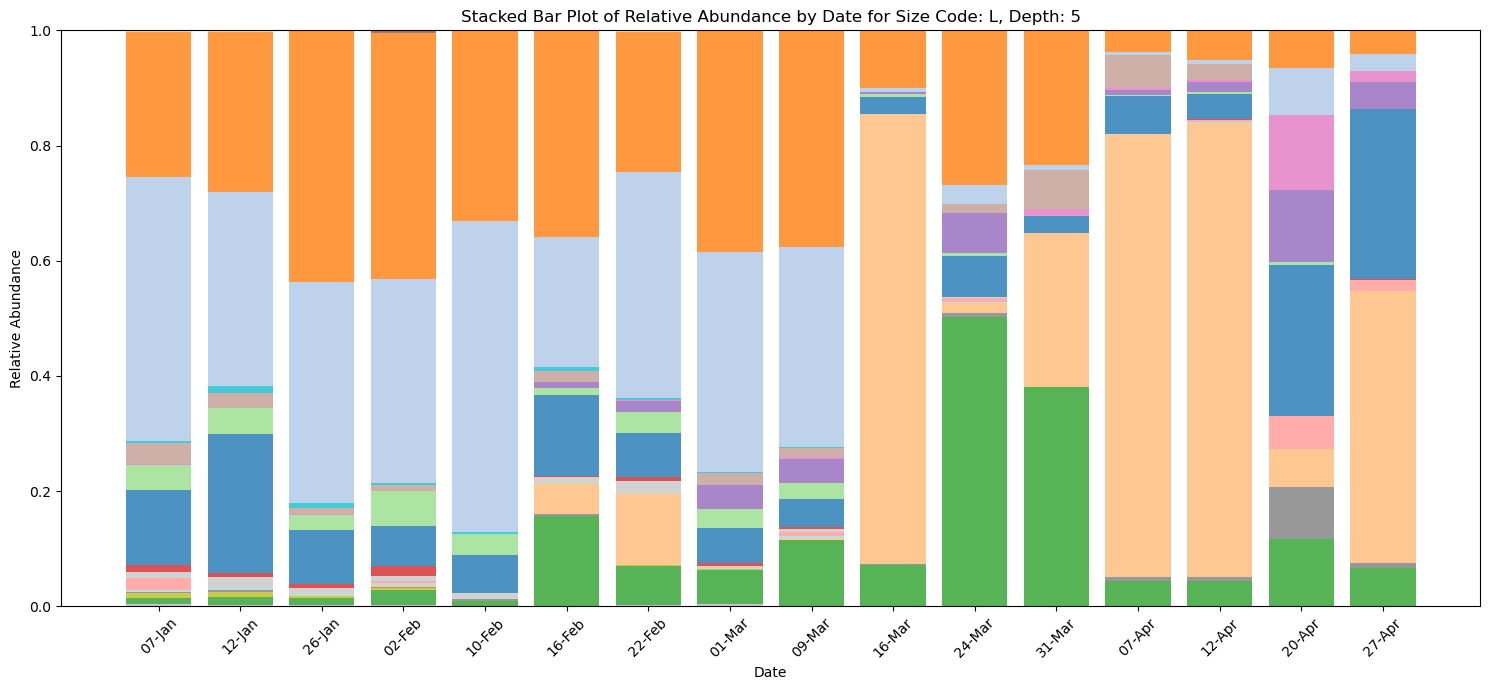

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


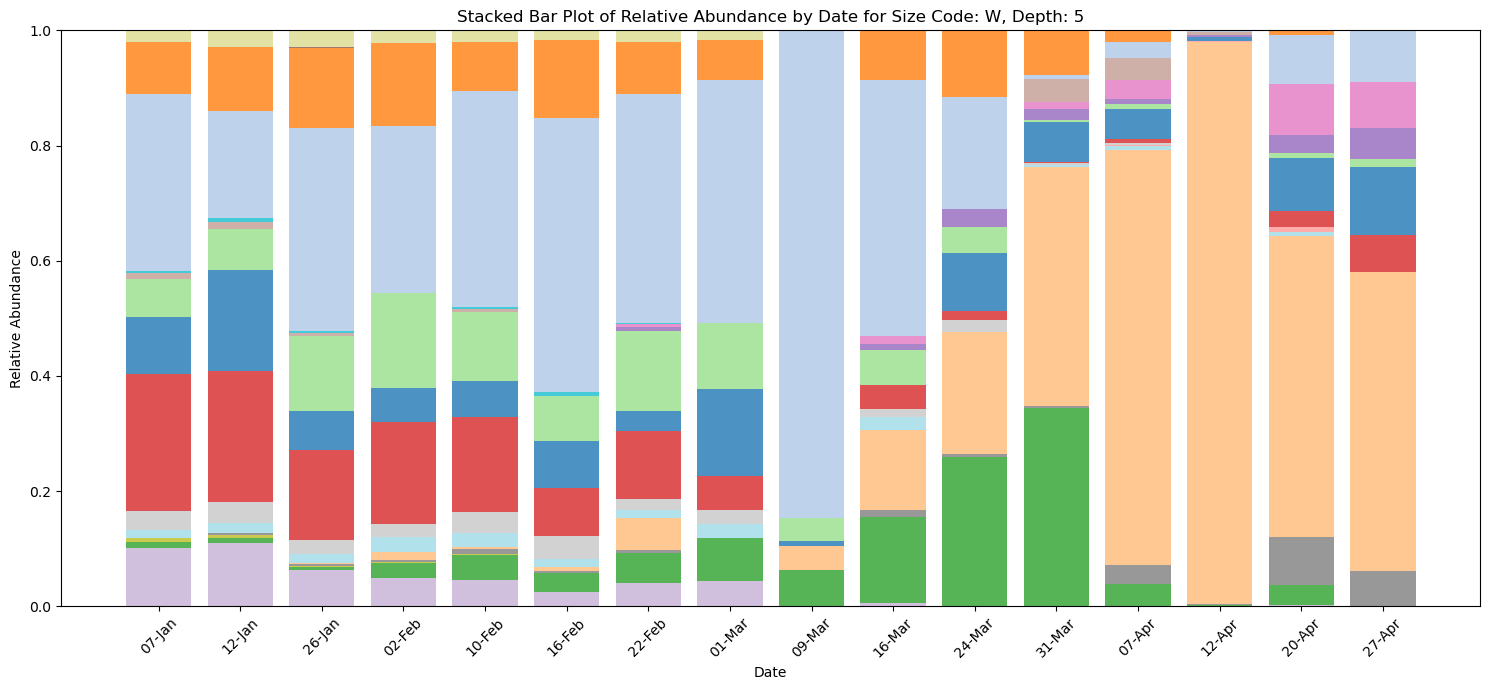

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


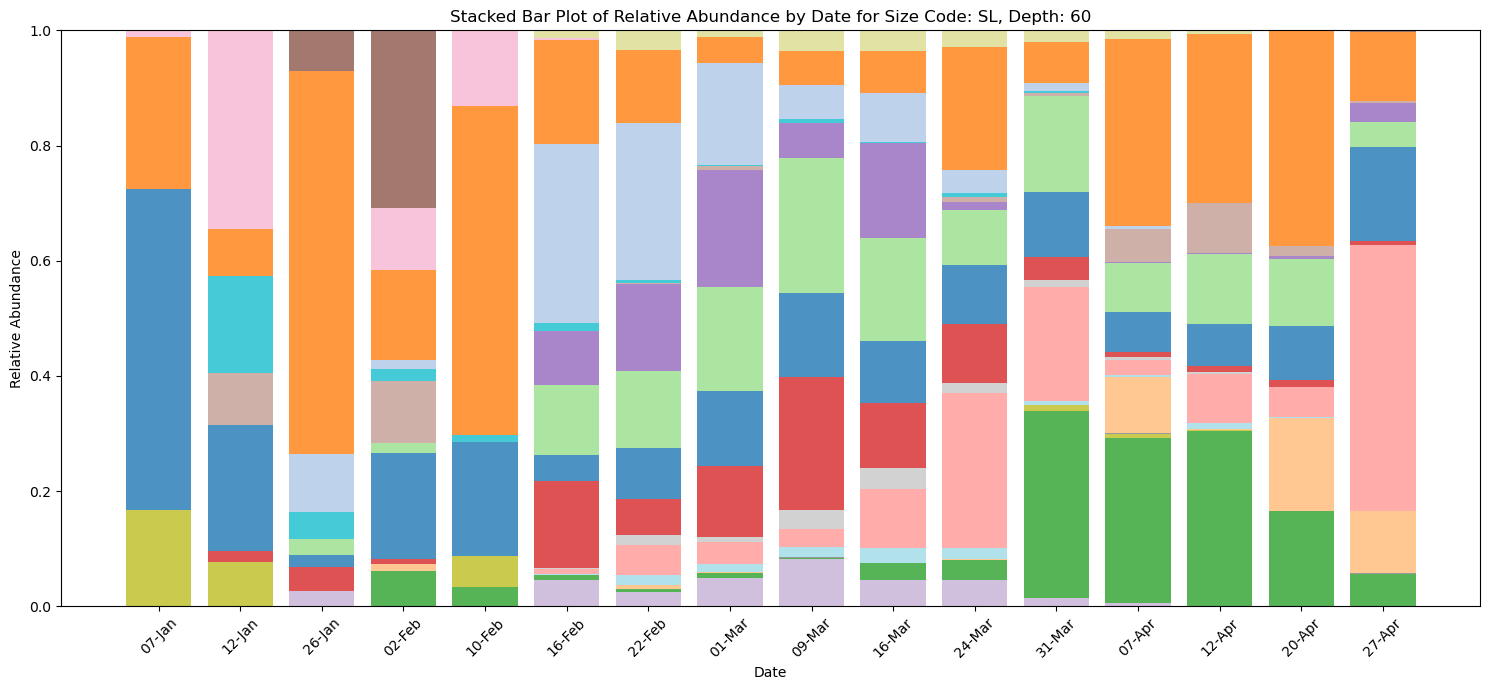

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


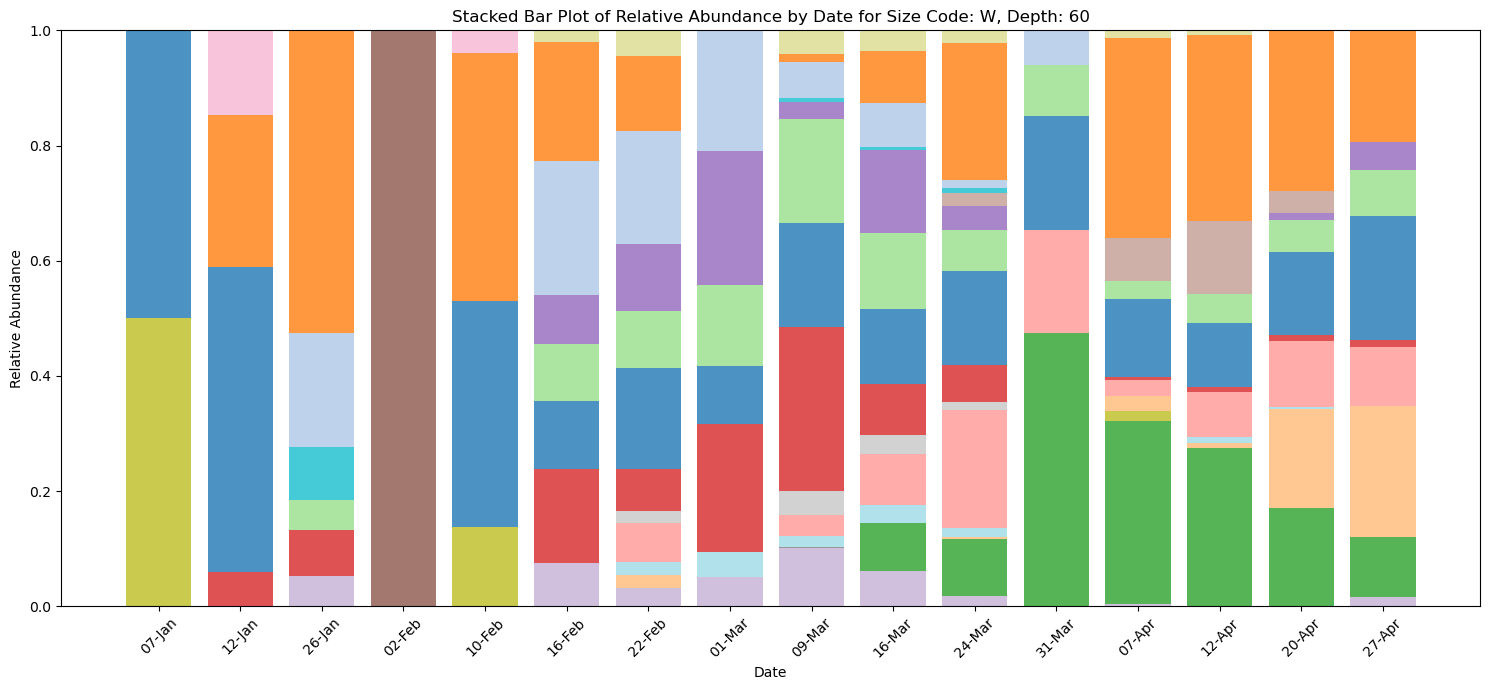

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


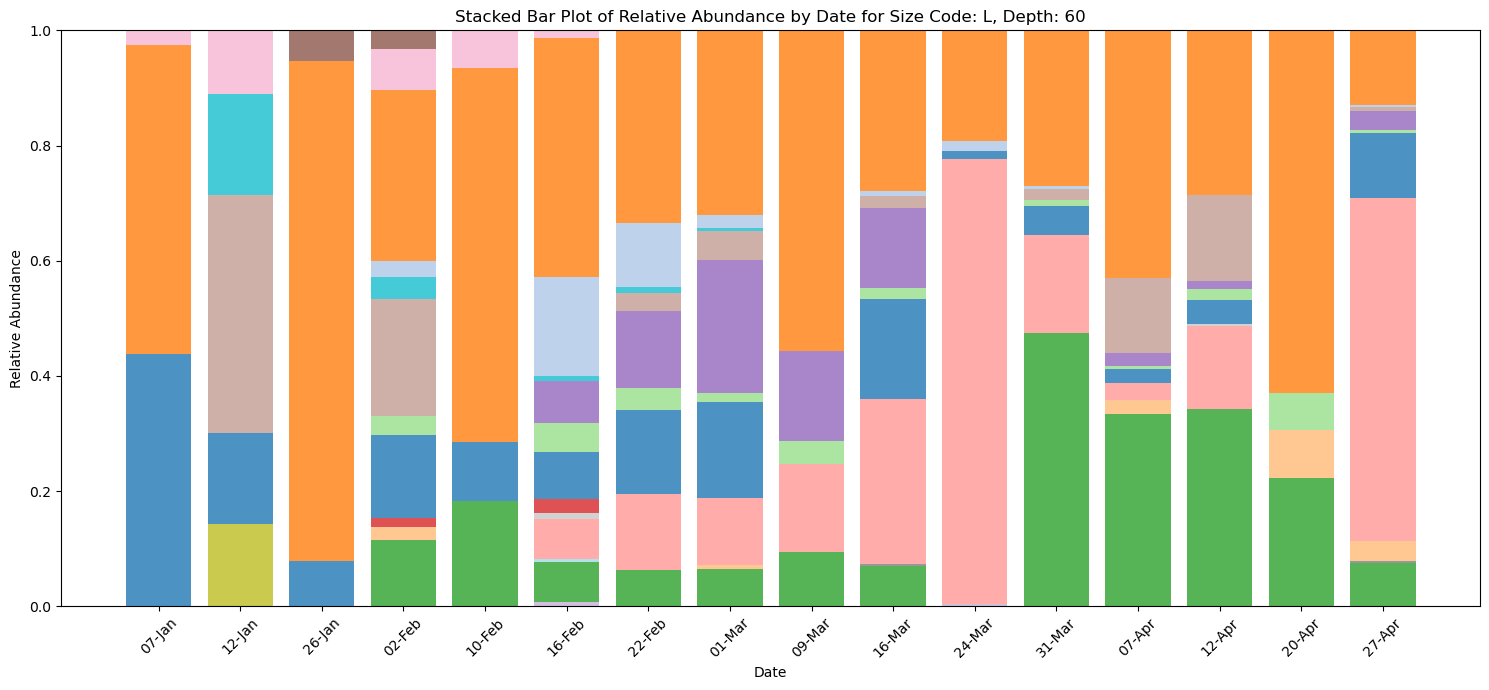

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


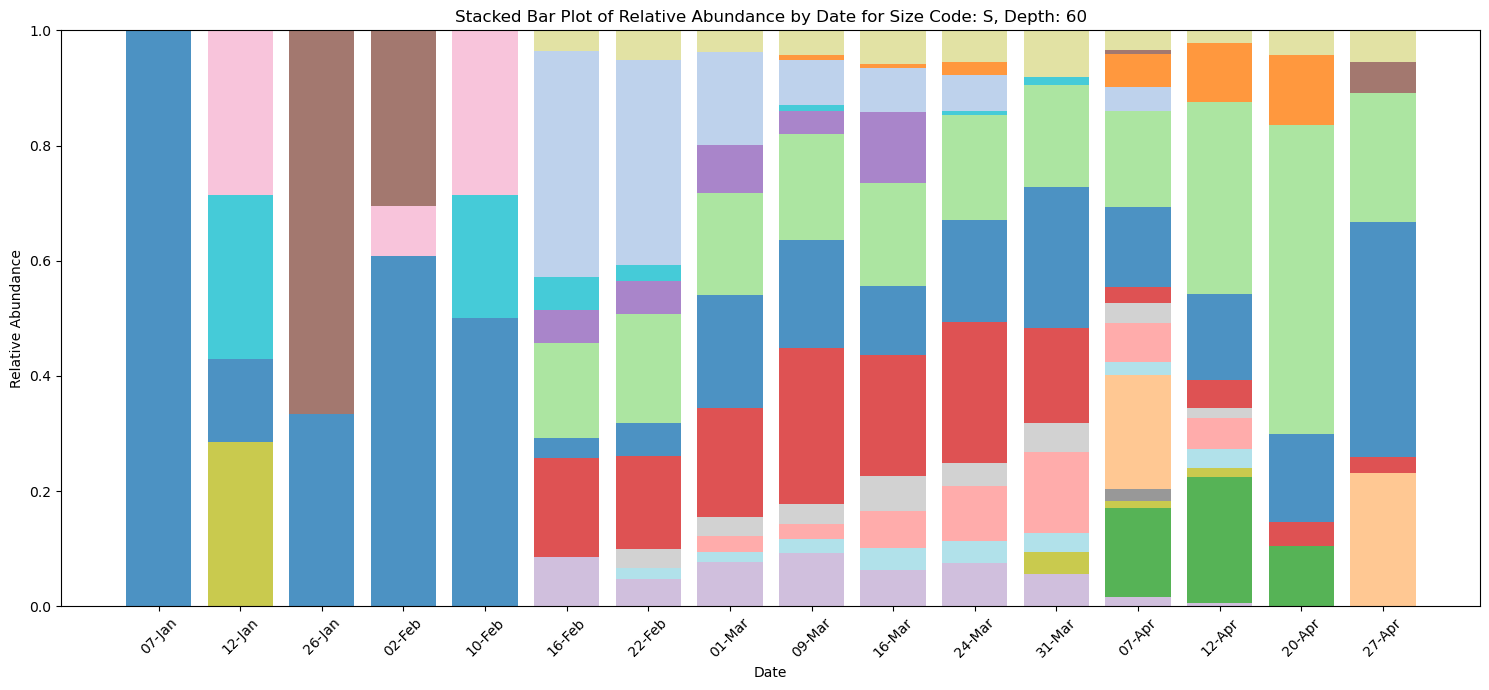

<Figure size 1000x100 with 0 Axes>

In [6]:
#Visualize the static barplots with seaborn, and each size fraction separately
taxonomic_barplots(comm, newdf, [5,60], 'PRSpecies', 20)

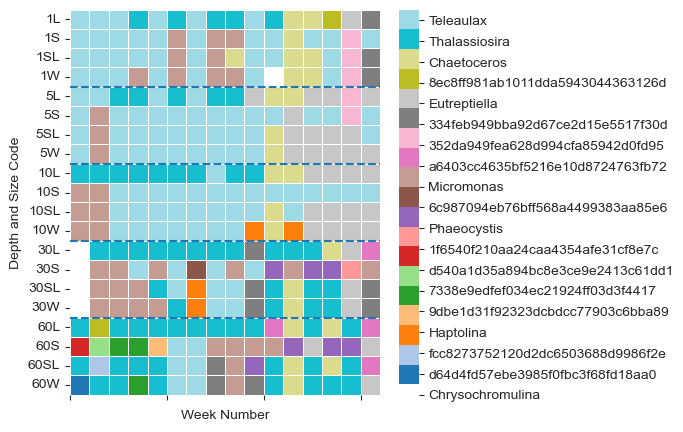

In [18]:
#Generate the heatmap for the top genus from each sample
heatmap_top1(comm, newseparated, 'Genus')

The above plot uses taxonomy, but we can generate the same plot but by comparing whether 80% of the features in each samples are also found in the whole (unfractionated samples). This was quantified by dividing the number of shared features by the toal number of features. If a square has a red color (closer to 1), it's very similar to the unfractionated sample, and the bluer the square, the more different it is from the unfractionated.

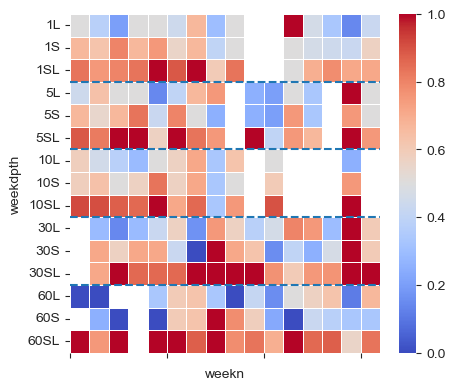

In [27]:
grab_80perc(comm, newseparated, 0.8, 'feature_id')

We can plot alpha diversity measurements, whether as 'shannon_diversity' or 'nASVs' which is the richness quantified by the total number of ASVs

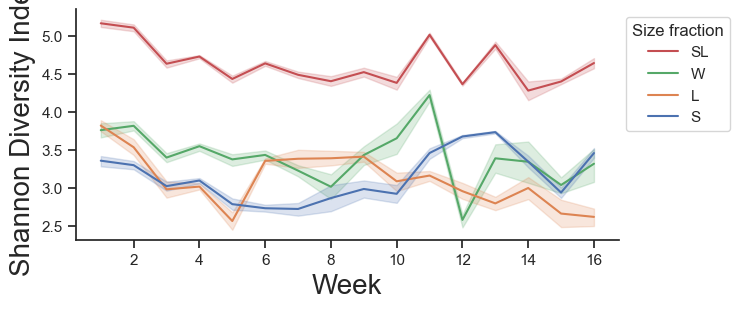

In [54]:
#run the visualisations for alpha diversity and run pairwise t-tests between size fractions for richness values
anova, results = boxplot_depth(newdf, comm, 'all', 'shannon_diversity', 'Shannon Diversity Index')
#results gives the corrected p-values for pairwise comparisons

Compare the slopes of linear regressions of the richness change over time. Each value represents how much a size fraction (column) differs in comparison to the average slope (averaged between all size fractions) for each depth (rows).

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:2417: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



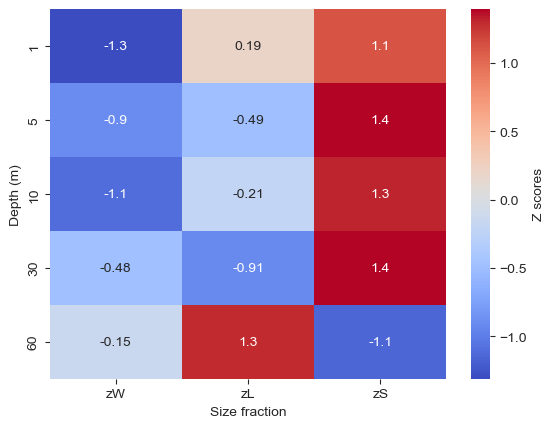

In [26]:
tohm, z_sc_df = get_slopes(comm, separated)
#a zscore of 1= 1 std away from the mean,
#positive values=higher than mean, neg= smaller than mean

### ANCOM analysis

Optionally we can run ANCOM with removed low abundance features with a given threshold

In [ ]:
#only if we want to run ANCOM pairwise
news2 = newseparated[newseparated.size_code != 'L']
news2 = news2[news2.size_code != 'SL']

In [ ]:
depths = [1,5,10,30,60]
for depth in depths:
    pca, pca_features, sfdclr, dm = pcaplot(newseparated, depth, comm, 'size_code', 'DFr', 'week')
    DAresults, DARejected_SC_taxonomy, prcentile = run_ancom(comm, newseparated, sfdclr, depth, 'size_code', threshold=0)

    #save outputs
    DAresults.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_WSLSL.csv')
    DARejected_SC_taxonomy.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_Trueonly_WSLSL.csv')

    notify()

Depending on ancom results, we can investigate single features temporal dynamics

In [7]:
f_id = 'ec0cef5115e1a5e72ba718c19f44ac1e'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

'd__Eukaryota; p__Dinoflagellata; c__Dinophyceae; o__Gymnodiniphycidae; f__Gymnodiniphycidae'

Visualize the time series of a single feature in each size fraction over the 16 weeks

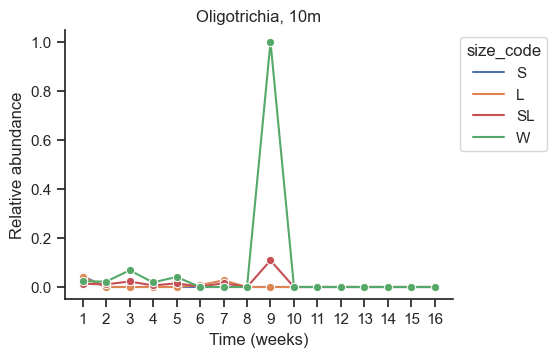

In [41]:
timeseries_fid(comm, newseparated, f_id, 'Oligotrichia', 10)

In [ ]:
feature_id_summary = count_feature_id_presence_with_depth_and_W('outputs', comm)
top_asvs_summary = filter_top_asvs(feature_id_summary, method="top_W_sum", n=50)
plot_asv_heatmap(comm, feature_id_summary, file_filter="WSLSL")